## Common Information Demo

Author: Cheuk Ting Li  

In [1]:
import numpy
import matplotlib.pyplot as plt
from psitip import *
PsiOpts.setting(solver = "pyomo.glpk")  # Set linear programming solver
PsiOpts.setting(repr_latex = True)      # Turn on Jupyter Notebook LaTeX display
PsiOpts.setting(venn_latex = True)      # Turn on LaTeX in diagrams
PsiOpts.setting(istorch = True)         # Enable pytorch

X, Y, Z, W, U, M, S = rv("X, Y, Z, W, U, M, S") # Declare random variables

In [2]:
# Gács-Körner common information [Gács-Körner 1973]
gacs_korner(X & Y) == gacs_korner(X & Y).definition()

gacs_korner(X&Y) == (( ( H(U|X) == 0 )
 &( H(U|Y) == 0 ) ).exists(U)).maximum(H(U)) 

In [3]:
# Wyner's common information [Wyner 1975]
wyner_ci(X & Y) == wyner_ci(X & Y).definition()

wyner_ci(X&Y) == (( ( markov(X, U, Y) ) ).exists(U)).minimum(I(U&X+Y)) 

In [4]:
# Common entropy [Kumar-Li-El Gamal 2014]
exact_ci(X & Y) == exact_ci(X & Y).definition()

exact_ci(X&Y) == (( ( markov(X, U, Y) ) ).exists(U)).minimum(H(U)) 

In [5]:
# Automatically discover inequalities among quantities
universe().discover([X, Y, 
                     gacs_korner(X & Y), 
                     wyner_ci(X & Y), 
                     exact_ci(X & Y)])

( ( gacs_korner(X&Y) >= 0 )
 &( wyner_ci(X&Y) <= exact_ci(X&Y) )
 &( exact_ci(X&Y) <= H(X) )
 &( exact_ci(X&Y) <= H(Y) )
 &( gacs_korner(X&Y) <= I(X&Y) )
 &( I(X&Y) <= wyner_ci(X&Y) ) )

------

### Alternative Characterization of Gács-Körner Common Information

In [6]:
# Equivalent characterization using mutual information [Gray-Wyner 1974]
gacs_korner_mi(X & Y) == gacs_korner_mi(X & Y).definition()

gacs_korner_mi(X&Y) == (( ( markov(U, Y, X) )
 &( markov(U, X, Y) ) ).exists(U)).maximum(I(U&X+Y)) 

In [7]:
# To prove they are equivalent, we need the double Markov property [Csiszar-Korner 2011]
with dblmarkov().assumed():
    (gacs_korner_mi(X & Y) <= gacs_korner(X & Y)).display_bool()
    (gacs_korner_mi(X & Y) >= gacs_korner(X & Y)).display_bool()

<IPython.core.display.Math object>

<IPython.core.display.Math object>

------

### Data Processing Inequality

In [8]:
r = markov(X, Y, Z)  # X -> Y -> Z forms a Markov chain
(r >> (gacs_korner(X & Y) >= gacs_korner(X & Z))).display_bool()

<IPython.core.display.Math object>

In [9]:
(r >> (wyner_ci(X & Y) >= wyner_ci(X & Z))).display_bool()

<IPython.core.display.Math object>

In [10]:
(r >> (exact_ci(X & Y) >= exact_ci(X & Z))).display_bool()

<IPython.core.display.Math object>

------

### Tensorization / Additivity

In [11]:
r = indep(X + Y, Z + W)  # (X,Y) is independent of (Z,W)

# Gács-Körner common information is additive
(r >> (gacs_korner_mi(X & Y) + gacs_korner_mi(Z & W) >= gacs_korner_mi(X+Z & Y+W))).display_bool()
(r >> (gacs_korner_mi(X & Y) + gacs_korner_mi(Z & W) <= gacs_korner_mi(X+Z & Y+W))).display_bool()

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [12]:
# Wyner's common information is additive
(r >> (wyner_ci(X & Y) + wyner_ci(Z & W) >= wyner_ci(X+Z & Y+W))).display_bool()
(r >> (wyner_ci(X & Y) + wyner_ci(Z & W) <= wyner_ci(X+Z & Y+W))).display_bool()

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [13]:
# Common entropy is only subadditive
(r >> (exact_ci(X & Y) + exact_ci(Z & W) >= exact_ci(X+Z & Y+W))).display_bool()
(r >> (exact_ci(X & Y) + exact_ci(Z & W) <= exact_ci(X+Z & Y+W))).display_bool()

<IPython.core.display.Math object>

<IPython.core.display.Math object>

------

### Numerical Evaluation for Binary Symmetric Source

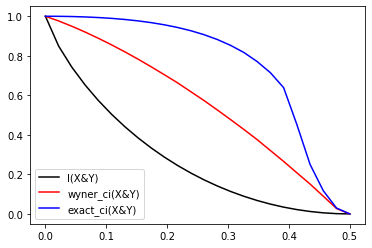

In [14]:
# Switch to basin-hopping for nonconvex optimization
PsiOpts.setting(opt_basinhopping = True)

PsiOpts.setting(opt_aux_card = 2)    # Default cardinality for auxiliary
PsiOpts.setting(opt_num_points = 24) # Number of initial points to try
PsiOpts.setting(opt_num_hop = 4)     # Number of hops
PsiOpts.setting(opt_num_iter = 8)    # Number of iterations per hop

X, Y = rv("X, Y").set_card(2)     # X,Y are binary RVs (cardinality = 2)
P = ConcModel()                   # Underlying distribution of RVs
P[X] = [0.5, 0.5]                 # X is a fair bit

ts = numpy.linspace(0.0, 0.5, 24)
ms, js, gs = [], [], []
for t in ts:
    P[Y | X] = [[1-t, t], [t, 1-t]]  # P(Y|X) is BSC(t)
    ms.append(P[I(X & Y)])           # Evaluate mutual information
    js.append(P[wyner_ci(X & Y)])    # Wyner's common information
    gs.append(P[exact_ci(X & Y)])    # Common entropy

# Plot the quantities against t
plt.figure()
plt.plot(ts, ms, 'k', label = str(I(X & Y)))
plt.plot(ts, js, 'r', label = str(wyner_ci(X & Y)))
plt.plot(ts, gs, 'b', label = str(exact_ci(X & Y)))
plt.legend()
plt.show()

### References
- P. Gács and J. Körner, "Common information is far less than mutual information," Problems Control Inf. Theory, vol. 2, no. 2, pp. 149–162, 1973.
- A. D. Wyner, "The common information of two dependent random variables," IEEE Trans. Inf. Theory, vol. IT-21, no. 2, pp. 163-179, Mar. 1975.
- G. R. Kumar, C. T. Li, and A. El Gamal, "Exact common information," in Proc. IEEE Symp. Info. Theory. IEEE, 2014, pp. 161-165.
- R. M. Gray and A. D. Wyner, "Source coding for a simple network," Bell Syst. Tech. J., vol. 53, no. 9, pp. 1681–1721, 1974.
- I. Csiszár and J. Körner, "Information theory: coding theorems for discrete memoryless systems," Cambridge University Press, 2011.
- C. T. Li and A. El Gamal, "Extended Gray–Wyner system with complementary causal side information," IEEE Trans. Inf. Theory, vol. 64, no. 8, pp. 5862–5878, 2017
